In [1]:
import pandas as pd
import sqlite3
import openai
import os
from dotenv import load_dotenv


In [2]:
def get_database_schema(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Fetch all table names in the database
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()

    schema = {}
    for table in tables:
        table_name = table[0]
        # Get all column names for each table
        cursor.execute(f"PRAGMA table_info({table_name});")
        columns = [info[1] for info in cursor.fetchall()]
        schema[table_name] = columns

    conn.close()
    return schema

# Example usage:
schema = get_database_schema('data.sqlite')


In [3]:
schema

{'alembic_version': ['version_num'],
 'users': ['id',
  'username',
  'password_hash',
  'first_name',
  'last_name',
  'is_active',
  'is_admin',
  'created_on',
  'last_updated_on'],
 'patients': ['id',
  'created_by',
  'last_updated_by',
  'created_on',
  'last_updated_on',
  'first_name',
  'last_name',
  'father_name',
  'date_of_birth',
  'marital_status',
  'nationality',
  'occupation',
  'street_name',
  'street_number',
  'city',
  'postal_code',
  'county',
  'home_phone',
  'mobile_phone',
  'alternative_phone',
  'email',
  'insurance',
  'insurance_comment',
  'amka',
  'spouse_name',
  'spouse_date_of_birth',
  'spouse_occupation',
  'is_active']}

In [3]:
# Convert dictionary to a DataFrame
df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in schema.items()]))

# Display the DataFrame nicely in Jupyter
# df

In [4]:
dotenv_path = os.path.join('..', 'keys.env')
load_dotenv(dotenv_path)
api_key=os.getenv("OPENAI_API_KEY")

In [5]:
def generate_sql_query(user_query, schema, api_key):
    openai.api_key = api_key
    
    # Prepare the schema information as part of the system message
    schema_prompt = "Here is the database schema:\n"
    for table, columns in schema.items():
        schema_prompt += f"Table: {table}\nColumns: {', '.join(columns)}\n"
    
    # Use the Chat Completion API (for models like GPT-4)
    messages = [
        {
            "role": "system",
            "content": (
                "You are a SQL expert specialized in SQLite. Based on the user's question and the following database schema, "
                "generate only a valid SQL query. Ensure that Greek names remain in Greek, without transliteration. "
                "Do not provide any explanations, comments, or additional context—only return the SQL query as plain text.\n"
                "When calculating dates or ages, make sure to use SQLite-compatible functions like strftime().\n\n"
                + schema_prompt
            )
        },
        {
            "role": "user",
            "content": f"User query: {user_query}"
        }
    ]
    
    response = openai.ChatCompletion.create(
        model="gpt-4",  # Ensure you're using a chat-based model
        messages=messages,
        max_tokens=150,
        temperature=0,
        top_p=1,
    )
    
    # Extract the SQL query from the assistant's reply
    sql_query = response['choices'][0]['message']['content'].strip()
    # print(f"Generated SQL Query: {sql_query}") 
    return sql_query

sql_query = generate_sql_query("Μια λίστα με τους πελάτες μου από 20 μέχρι 22 χρονών. Αριθμό πελάτη και ονοματεπώνυμο;", schema, api_key=api_key)


In [6]:
def execute_sql_query(sql_query, db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    cursor.execute(sql_query)
    result = cursor.fetchall()

    conn.close()
    return result

# sql_query = """
# SELECT 
#     (strftime('%Y', 'now') - strftime('%Y', date_of_birth)) - 
#     (strftime('%m-%d', 'now') < strftime('%m-%d', date_of_birth)) AS age
# FROM 
#     patients
# WHERE 
#     first_name = 'Φανή' AND last_name = 'Βασιλειάδου';
# """


# Example usage:
result = execute_sql_query(sql_query, db_path="data.sqlite")
print(result)

[(687, 'ΕΜΜΑΝΟΥΕΛΑ', 'ΒΕΚΡΗ'), (716, 'ΜΙΧΑ', 'ΕΥΑ'), (768, 'ΠΑΠΑΝΙΚΟΛΑΟΥ', 'ΣΟΦΙΑ'), (910, 'ΑΝΔΡΟΜΑΧΗ', 'ΠΕΤΡΟΥ'), (955, 'chiara', 'trettow'), (1078, 'ΑΓΙΩΤΗ', 'ΑΝΑΣΤΑΣΙΑ'), (1143, 'ΛΕΜΕ', 'ΕΙΡΗΝΗ'), (1163, 'ΒΛΑΧΟΥ', 'ΔΕΣΠΟΙΝΑ'), (1170, 'ΝΤΟΣΤΗ', 'ΣΟΝΙΑ'), (1171, 'ΣΥΝΝΕΦΑΚΗ', 'ΒΑΣΙΛΙΚΗ'), (1178, 'ΚΑΝΔΑΡΑΚΗ', 'ΦΛΩΡΑ'), (1200, 'ΚΟΚΚΙΝΑΚΗ', 'ΜΑΡΙΑ'), (1259, 'ΣΙΩΜΟΥ', 'ΚΩΝΣΤΑΝΤΙΝΑ'), (1288, 'ΜΕΛΙΝΑ', 'ΠΑΝΤΑΖΟΠΟΥΛΟΥ'), (1322, 'ΜΑΡΙΑ', 'ΝΟΥΣΗ'), (1323, 'ΕΡΡΙΚΑ', 'ΝΟΥΣΗ'), (1342, 'ΜΕΛΙΝΑ', 'ΚΡΕΤΣΟΥ'), (1351, 'ΕΥΑΓΓΕΛΙΑ', 'ΠΩΓΩΝΙΔΟΥ'), (1397, 'ΠΗΓΗ', 'ΔΗΛΕ'), (1432, 'ΜΠΛΕΟΝΑ', 'ΛΑΜΑ'), (1440, 'ΠΑΠΑΚΩΝΣΤΑΝΤΙΝΟΥ', 'ΚΑΤΕΡΙΝΑ'), (1442, 'ΒΛΑΒΙΑΝΟΥ', 'ΜΑΡΓΑΡΙΤΑ'), (1463, 'ΕΥΓΕΝΙΑ', 'ΚΑΣΑΠΗ'), (1467, 'ΒΑΣΙΛΕΙΑ', 'ΤΖΕΛΕΠΗ'), (1468, 'ΒΑΣΙΛΕΙΑ', 'ΤΖΕΛΕΠΗ'), (1472, 'ΜΑΡΘΑ', 'ΤΣΟΠΑΝΟΓΛΟΥ')]


In [7]:
import openai

def synthesize_response(user_query, data, api_key):
    openai.api_key = api_key
    
    # Build a conversation prompt where the data retrieved from the database is included
    data_context = f"Retrieved data: {data}\n"

    # Messages for the chat model (GPT-4) to synthesize the final response
    messages = [
        {
            "role": "system",
            "content": "You are a helpful assistant that provides concise and accurate answers based on user queries and retrieved data."
        },
        {
            "role": "user",
            "content": f"User query: {user_query}"
        },
        {
            "role": "system",
            "content": data_context  # Provide the retrieved data as context for GPT-4
        }
    ]
    
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=messages,
        max_tokens=1000,
        temperature=0,
        top_p=1,
    )
    
    final_response = response['choices'][0]['message']['content'].strip()
    return final_response

# Example usage:
final_response = synthesize_response("How many customers do I have?", result, api_key=api_key)
print(final_response)


You have 27 customers.


In [8]:
def rag_pipeline(user_query, db_path='data.sqlite', api_key=None):
    # Step 1: Get the database schema dynamically
    schema = get_database_schema(db_path)
    # print(f"Database Schema: {schema}")  # Optional: to visualize the database schema
    
    # Step 2: Generate the SQL query from the user's natural language question
    sql_query = generate_sql_query(user_query, schema, api_key)
    # print(f"Generated SQL Query: {sql_query}")  # Optional: to visualize the generated SQL
    
    # Step 3: Execute the SQL query and retrieve data from the database
    result = execute_sql_query(sql_query, db_path)
    # print(f"Retrieved Data: {result}")  # Optional: to visualize the retrieved
    
    # Step 4: Synthesize the final response using GPT-4
    final_response = synthesize_response(user_query, result, api_key)
    
    return final_response



In [9]:
user_query = "Μια λίστα με τους πελάτες μου από 20 μέχρι 22 χρονών."
# user_query = "Θέλω μια λίστα με τα duplicates με τους διπλούς πελάτες δίπλα στον αριθμό τους. Μπορείς να μου το δώσεις; Τα duplicates είναι άτομα με το ίδιο όνομα και επώνυμο. και θέλω τον αριθμό τους και το όνομα τους σε μορφή json; θέλω και τους δύο πελάτες που είναι duplicates να εμφανίζονται στην λίστα αλλά ο αριθμός τους να μη χρησιμοπποιείτε για την ανεύρεση των διπλοτύπων;"

response = rag_pipeline(user_query, db_path="data.sqlite", api_key=api_key)
print(response)

Here is a list of your customers aged between 20 and 22:

1. ΕΜΜΑΝΟΥΕΛΑ ΒΕΚΡΗ
2. ΜΙΧΑ ΕΥΑ
3. ΠΑΠΑΝΙΚΟΛΑΟΥ ΣΟΦΙΑ
4. ΑΝΔΡΟΜΑΧΗ ΠΕΤΡΟΥ
5. Chiara Trettow
6. ΑΓΙΩΤΗ ΑΝΑΣΤΑΣΙΑ
7. ΛΕΜΕ ΕΙΡΗΝΗ
8. ΒΛΑΧΟΥ ΔΕΣΠΟΙΝΑ
9. ΝΤΟΣΤΗ ΣΟΝΙΑ
10. ΣΥΝΝΕΦΑΚΗ ΒΑΣΙΛΙΚΗ
11. ΚΑΝΔΑΡΑΚΗ ΦΛΩΡΑ
12. ΚΟΚΚΙΝΑΚΗ ΜΑΡΙΑ
13. ΣΙΩΜΟΥ ΚΩΝΣΤΑΝΤΙΝΑ
14. ΜΕΛΙΝΑ ΠΑΝΤΑΖΟΠΟΥΛΟΥ
15. ΜΑΡΙΑ ΝΟΥΣΗ
16. ΕΡΡΙΚΑ ΝΟΥΣΗ
17. ΜΕΛΙΝΑ ΚΡΕΤΣΟΥ
18. ΕΥΑΓΓΕΛΙΑ ΠΩΓΩΝΙΔΟΥ
19. ΠΗΓΗ ΔΗΛΕ
20. ΒΑΣΙΛΕΙΑ ΤΖΕΛΕΠΗ
21. ΕΥΓΕΝΙΑ ΚΑΣΑΠΗ
22. ΒΑΣΙΛΕΙΑ ΤΖΕΛΕΠΗ
23. ΜΑΡΘΑ ΤΣΟΠΑΝΟΓΛΟΥ
24. ΜΑΡΘΑ ΤΣΟΠΑΝΟΓΛΟΥ


In [11]:
# Function to handle the recursive question-answer process
def ask_questions():
    while True:
        user_query = input("Enter your question (or type 'exit' to quit): ")
        print(user_query)
        
        # Exit condition
        if user_query.lower() == 'exit':
            print("Exiting the question-answer loop.")
            break

        # Process the query using your pipeline
        response = rag_pipeline(user_query, db_path="data.sqlite", api_key=api_key)
        print(response)  # Print the response for the current query

# Call the function to start the loop
ask_questions()


Πόσο χρονών είναι η Φανή Βασιλειάδου
Η Φανή Βασιλειάδου είναι 79 ετών.
και πόσα παιδιά έχει η ασθενής αυτή;


OperationalError: near "Sorry": syntax error

In [12]:
import yfinance as yf

tickers = ["SPY"]
data = yf.download(tickers, period="max", interval="1h")
print(data['Close'].tail())

C:\Users\Zacharias.Detorakis\AppData\Local\Temp\ipykernel_6832\2951430408.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period="max", interval="1h")
[*********************100%***********************]  1 of 1 completed

Ticker                            SPY
Datetime                             
2025-08-06 17:30:00+00:00  632.919983
2025-08-06 18:30:00+00:00  633.020020
2025-08-06 19:30:00+00:00  632.669983
2025-08-07 13:30:00+00:00  633.820007
2025-08-07 14:30:00+00:00  632.640015


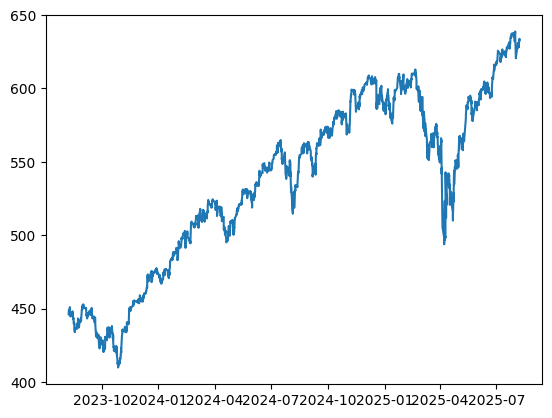

In [13]:
from matplotlib.pyplot import plot

plot(data['Close'])
